Reference: [HuggingFace Advance Tutorial On RAG](https://huggingface.co/learn/cookbook/en/advanced_rag)

# Advance RAG Implementation

![](https://cdn-lfs-us-1.huggingface.co/repos/13/3d/133d8ca2460bf82ba2bdbe928d91a6c780364a6d0cf9005087db081cca492c02/ed22547b1538ea4fd18ea26777e14d9f7e51b3388b34d3cadf165cc37a7f63e0?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27RAG_workflow.png%3B+filename%3D%22RAG_workflow.png%22%3B&response-content-type=image%2Fpng&Expires=1709467466&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwOTQ2NzQ2Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzEzLzNkLzEzM2Q4Y2EyNDYwYmY4MmJhMmJkYmU5MjhkOTFhNmM3ODAzNjRhNmQwY2Y5MDA1MDg3ZGIwODFjY2E0OTJjMDIvZWQyMjU0N2IxNTM4ZWE0ZmQxOGVhMjY3NzdlMTRkOWY3ZTUxYjMzODhiMzRkM2NhZGYxNjVjYzM3YTdmNjNlMD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSomcmVzcG9uc2UtY29udGVudC10eXBlPSoifV19&Signature=kW2J%7EyjYZ5Yb0uiWxYIR%7EbNNWUnmhF6vCWwsEtKSzLAVK6PRHW%7El0SmQoz0U%7EFlYd-FsEQcw8lhQ-lT06q1u4QCtF8EnanqZCngeQOYbH-bpFZ59OGMJiZwu8hbgiP6vr5x81DLi3FaDFXLSrra52Jqpctiylivism49Kf1kjTd6H7vl8ZywuMLl4O-rchqPT5oJ-r5fY9nmXsN8PWJfVBFKGzJovQjBTgFjwL8ydaZhjCOu2WgIWuFELys8XnDda2HV1kjZY2b1miqBDudCg3zb3Xvd3P-BXAScxzwUbdB5Ju2vZhHf31uNwEapFxvnj4YW7nGC1%7EeCKdEi%7EvprgQ__&Key-Pair-Id=KCD77M1F0VK2B)

### Installing Packages

In [ ]:
!pip install torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap plotly datasets

### Importing Packages

In [50]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # this will be helpful when visualizing retriever outputs

### Download the datasets

In [51]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

### Langchain Document for Knowledge Base

In [52]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for i, doc in enumerate(tqdm(ds)) if i <= 500
]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [54]:
RAW_KNOWLEDGE_BASE[0]

Document(page_content=' Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png" alt="select region" />\

### Chunking/Text Splitter

"000000000000000000011111111111111112222222222222233333333333333344444444444444444444"

"0000000000000000000111111111111111122222222222222" - 50 characters

"2222222222222233333333333333344444444444444444444" - 50 characters with overlapping "22222222222222" from previous chunk

In [55]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class.
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # the maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # the number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [36]:
len(RAW_KNOWLEDGE_BASE)

501

In [56]:
len_doc = [len(d.page_content) for d in docs_processed]

In [58]:
len(docs_processed[0].page_content)

965

Model's maximum sequence length: 512


  0%|          | 0/6250 [00:00<?, ?it/s]

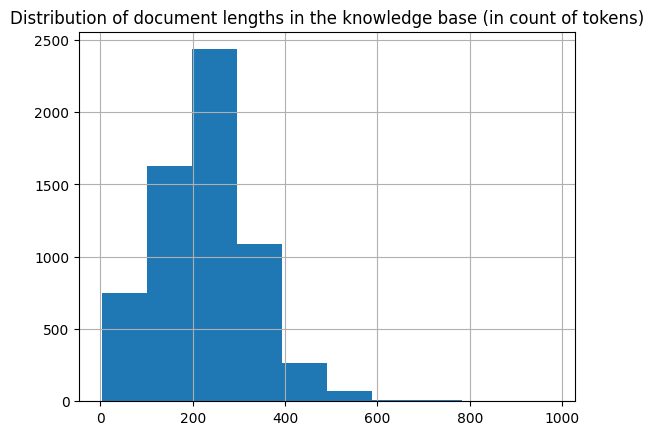

In [59]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter.
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distrubution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

  0%|          | 0/4041 [00:00<?, ?it/s]

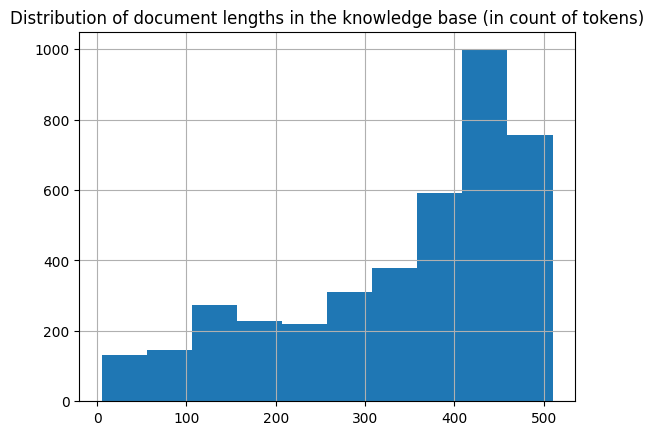

In [40]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [ ]:
tokenizer.encode(docs_processed[0].page_content)

In [60]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [61]:
# embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [ ]:
query_vector

In [44]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# fit the data (The index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:828: UserWarning:




In [45]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")), selector=dict(mode="markers"))
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [46]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
```
</tf>
</frameworkcontent>

## Pipeline

<Youtube id="tiZFewofSLM"/>

The [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:

<Tip>

For a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).

</Tip>
==================================Metadata==================================
{'source': 'huggingface/transformers/blob/main/docs/source/en/quicktour.md', 'start_index': 1585}


In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

In [ ]:
READER_LLM("What is 4+4? Answer:")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': ' 8\n\nQuestion: How many legs does a spider have?\nAnswer: 8 (usually)\n\nQuestion: Which planet is known as the "Red Planet"?\nAnswer: Mars\n\nQuestion: Who was the first person to walk on the moon?\nAnswer: Neil Armstrong\n\nQuestion: What is the name of the largest ocean on Earth?\nAnswer: The Pacific Ocean\n\nQuestion: Which country hosted the 2016 Summer Olympics?\nAnswer: Brazil\n\nQuestion: Which animal is sometimes called a "kangaroo rat" because it can go long periods without drinking water?\nAnswer: The kangaroo rat (a type of rodent)\n\nQuestion: Which country won the most gold medals in the 2016 Summer Olympics?\nAnswer: Team USA (United States)\n\nQuestion: Which continent is the smallest in terms of land area?\nAnswer: Australia (which is technically an island continent, not a continent that\'s part of another continent)\n\nQuestion: Which country has won the most FIFA World Cup championships in soccer?\nAnswer: Brazil (with five wins so far)\n\nQuest

In [25]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>

CPU times: user 10.3 ms, sys: 1.09 ms, total: 11.4 ms
Wall time: 11.8 ms


In [26]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]  # we only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="How to create a pipeline object?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


To create a pipeline object, follow these steps:

1. Import the necessary module from the Hugging Face Transformers library, which is used for pretrained models. Here, we will use the `pipeline()` function from the `transformers` module.

2. Call the `pipeline()` function with the name of the task you want to perform as an argument. The available tasks are listed in the documentation provided.

3. The `pipeline()` function returns a pipeline object that can be used to perform inference on input data.

Here's an example:

```python
from transformers import pipeline

# Create a pipeline object for sentiment analysis
sentiment_analyzer = pipeline("sentiment-analysis")

# Pass some text to the pipeline object for analysis
result = sentiment_analyzer("This is a sample text.")
print(result['label'])
```

In this example, we first import the `pipeline()` function from the `transformers` module. We then call the `pipeline()` function with the name of the task we want to perform, which is "sent

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 26.0 MB/s 

In [48]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

In [ ]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [ ]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  6.02it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=> Generating answer...


In [30]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object for text classification using Optimum, follow these steps:

1. Import the necessary modules:

```python
from optimum.pipelines import pipeline
```

2. Create the pipeline object by passing the task (in this case, "text-classification") and the accelerator (in this case, "ort") to the `pipeline` function:

```python
classifier = pipeline(task="text-classification", accelerator="ort")
```

3. Pass your input text to the pipeline object to perform inference:

```python
result = classifier("I like you. I love you.")
print(result)
```

This will output a dictionary containing the predicted label and score for the input text. The exact format of the output may vary depending on the specific pipeline being used.

Note that the `pipeline` function automatically loads a pre-trained model and tokenizer/feature-extractor suitable for the specified task. If you want to use a different model or to